# Dive

wrapped in a python class

## Implementation

 - Dive profile is usually shown as a series of depth and time, in `MM:SS` format, points.
   - Need to convert the latter into decimal minutes,
   - and convert it to time and current depth.

 - constructor: initialize the model to ZH-L16C w/ 5-minute compartment,
   - diving air,
   - at sea level,
   - using $ RQ = 0.9 $
   - and fixed gradient factor 0.85
 
 - `segment()` takes the new depth and time and updates gas loadings.
 
 This also keeps track of the ceiling together with $ P_t $


In [2]:
import pprint
import re

import diyzhl

#
#
class dive( object ) :
    
    # ctor
    #
    def __init__( self, verbose = False ) :

        self._verbose = bool( verbose )
        self._timepat = re.compile( r"(?:(\d{1,2}):)?(\d{1,2}):(\d{1,2})" )
        
# air, sea level, USN RQ. S is surface pressure (const), P is current pressure (var)
        self._T = 0
        self._S = 1.0
        self._P = self._S
        self._Q = 0.79
        self._RQ = 0.9
        self._GFHi = 0.85
        self._TCs = []

# starting Pt (same for all TCs)
        sp = diyzhl.palv( Pamb = self._P, Q = self._Q, RQ = self._RQ )

# use ZH-L16Cb (skip over 4-minute TC)
        for tc in diyzhl.ZHL16N.keys() :
            if tc == 1 : continue
            self._TCs.append( { 
                "t" : diyzhl.ZHL16N[tc]["t"], 
                "a" : diyzhl.ZHL16N[tc]["a"]["C"],
                "b" : diyzhl.ZHL16N[tc]["b"],
                "P" : sp
            } )

# init. ceiling
        for i in range( len( self._TCs ) ) :
            self._TCs[i]["C"] = diyzhl.buhlmann( Pn = self._TCs[i]["P"],
                                         an = self._TCs[i]["a"],
                                         bn = self._TCs[i]["b"],
                                         gf = self._GFHi )
            
        if self._verbose :
            pprint.pprint( self._TCs )
            
    # helpers for plotting
    # (could actually do this in a more "pythonic" way but this is more obvious)
    #
    @property
    def compartments( self ) :
        rc = []
        for i in range( len( self._TCs ) ) :
            rc.append( self._TCs[i]["t"] )
        return rc
    
    @property
    def loadings( self ) :
        rc = []
        for i in range( len( self._TCs ) ) :
            rc.append( self._TCs[i]["P"] )
        return rc

    # helper function: takes human-readable time string like "1:30" and returns minutes: 1.5
    #
    def _time( self, t = "0:0" ) :
        if t is None : return 0
        m = self._timepat.search( str( t ).strip() )
        if not m : raise Exception( "Invalid time string %s" % (t,) )
        rc = 0.0
        if m.group( 1 ) is not None :
            rc = float( m.group( 1 ) ) * 60.0
        rc += float( m.group( 2 ) )
        rc += float( m.group( 3 ) ) / 60.0
        return round( rc, 1 )

    # newdepth is new depth in 0.1 bar
    # timestr is time as [hours:]minutes:seconds string. *it is the total elapsed* time
    #
    def segment( self, newdepth = 0.0, newtimestr = "1:0" ) :
        assert float( newdepth ) >= 0.0
        if float( newdepth ) == 0.0 :
            newP = self._P
        else :
            newP = round( self._S + float( newdepth ) / 10, 1 )
        t = self._time( newtimestr ) - self._T
    
        for i in range( len( self._TCs ) ) :
            p = diyzhl.schreiner( Pi = self._TCs[i]["P"], 
                          Palv = diyzhl.palv( Pamb = self._P, Q = self._Q, RQ = self._RQ ), 
                          t = t, 
                          R = diyzhl.arr( d0 = self._P, dt = newP, t = t, Q = self._Q ),
                          k = diyzhl.kay( Th = self._TCs[i]["t"] ) )
            self._TCs[i]["P"] = p
            self._TCs[i]["C"] = diyzhl.buhlmann( Pn = self._TCs[i]["P"],
                                         an = self._TCs[i]["a"],
                                         bn = self._TCs[i]["b"],
                                         gf = self._GFHi )

        self._P = newP
        self._T += t
    
        if self._verbose :
            sys.stdout.write( "* At time %f, P %f:\n" % (self._T, self._P,) )
            pprint.pprint( self._TCs )


## Animate

The profile is from a real dive, simplified. 

(TODO: change bar colour when TC has a ceiling)

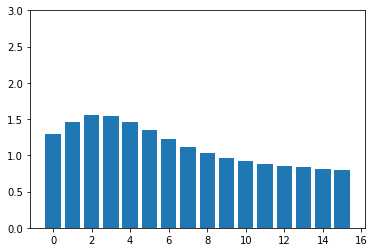

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

d = dive( verbose = False )
idx = np.arange( len( d.compartments ) )
plt.xticks( idx, d.compartments, rotation = 30 )
       

PROFILE = [(24,"1:40"),(30,"6:10"),(29,"10:20"),(23,"16:20"),(15,"21:30"),(10,"25:30"),(3,"40:0")]

for i in PROFILE : 
    display.clear_output( wait = True )
    d.segment( newdepth = i[0], newtimestr = i[1] )
    plt.ylim( 0, 3.0 )
    plt.bar( idx, d.loadings )
    plt.show()
    display.display( plt.gcf() )
    time.sleep( 1.5 )


